# Pre-processing workflow for MPAS-Ocean model output of basal melt rate

This notebook removes the linear trend, seasonal signal and extracts the draft dependence parameters for basal melt from the MPAS-Ocean SORRMv2.1 ocean model run.

This is a similar pre-processing workflow to that performed for the satellite observation dataset, except that the main output of this is the variability signal. 

Thus, we are not particularly interested in the draft dependence parameterizations which are an intermediate output in this file, however, they are saved for future reference. The dedraft prediction, instead, is used to remove the draft signal from the detrended, deseasonalized ocean model output data to finally get at the variability signal of interest.

Note that the detrend and deseasonalize functions now ensure the mean value of the raw dataset is added back in, so that draft parameterization incorporates the mean melt rate.

Once this draft signal is removed, what remains is the actual variability signal, which should be centered at a 0 value - and can be added on top of the mean signal to be used as an anomaly in the MALI simulations.

In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray
import random

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52183,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52198,Total threads: 2
Dashboard: http://127.0.0.1:52207/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:52186,


# Read datasets

In [2]:
# File path directories

# inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent

DIR_external = 'data/external/'
DIR_processed = 'data/processed/'
DIR_interim = 'data/interim/'

# DATASET FILEPATHS
# Ocean model output - E3SM (SORRMv2.1.ISMF), data received from Darin Comeau / Matt Hoffman at LANL
DIR_SORRMv21 = 'data/external/SORRMv2.1.ISMF/regridded_output/'

# INTERIM GENERATED FILEPATHS
DIR_SORRMv21_Interim = 'data/interim/SORRMv2.1.ISMF/iceShelves_dedraft/'

# DATA FILENAMES
FILE_SORRMv21 = 'Regridded_SORRMv2.1.ISMF.FULL.nc'

# Ice shelf basin/catchment definitions
FILE_iceShelvesShape = 'iceShelves.geojson'

In [3]:
yr1 = 300
yr2 = 900
SORRMv21 = xr.open_dataset(main_dir.parent / 'aislens_emulation/' / DIR_external / 'SORRMv2.1.ISMF/regridded_output/' / FILE_SORRMv21, chunks={"Time":36})
SORRMv21_flux = SORRMv21.timeMonthly_avg_landIceFreshwaterFlux[yr1*12:yr2*12]
SORRMv21_draft = SORRMv21.timeMonthly_avg_ssh

In [14]:
SORRMv21_flux_ts = SORRMv21_flux.mean(dim=['x','y']).compute()

In [4]:
ICESHELVES_MASK = gpd.read_file(main_dir / DIR_external / FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Helper Functions

In [5]:
# Helper functions

def detrend_dim(data, dim, deg):
    # Store the original mean
    #original_mean = data.mean(dim=dim)

    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    detrended = data - fit

    # Add back the original mean
    #detrended += original_mean

    return detrended

def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

def find_ice_shelf_index(ice_shelf_name):
    return icems[icems['name']==ice_shelf_name].index[0]

def deseasonalize(data):
    # Group data by month
    data_month = data.groupby("Time.month")

    # Calculate climatological mean for each month
    data_clm = data_month.mean("Time")
    
    # Calculate deseasonalized anomalies
    data_anm = data_month - data_clm
    
    # Add back the original mean
    original_mean = data.mean("Time")
    data_anm += original_mean
    
    return data_anm


def dedraft(data, draft):
    data_tm = data.mean(dim='time')
    draft_tm = draft.mean(dim='time')
    data_stack = data_tm.stack(z=('x', 'y'))
    draft_stack = draft_tm.stack(z=('x', 'y'))
    data_stack_noNaN = data_stack.fillna(0)
    draft_stack_noNaN = draft_stack.fillna(0)
    data_stack_noNaN_vals = data_stack_noNaN.values.reshape(-1,1)
    draft_stack_noNaN_vals = draft_stack_noNaN.values.reshape(-1,1)
    reg = LinearRegression().fit(draft_stack_noNaN_vals, data_stack_noNaN_vals)
    data_pred_stack_noNaN_vals = reg.predict(draft_stack_noNaN_vals).reshape(-1)
    data_pred_stack_noNaN = data_stack_noNaN.copy(data=data_pred_stack_noNaN_vals)
    data_pred_stack = data_pred_stack_noNaN.where(~data_stack.isnull(), np.nan)
    data_pred = data_pred_stack.unstack('z').transpose()
    data_dedraft = data - data_pred
    return reg.coef_, reg.intercept_, data_pred, data_dedraft

In [6]:
# Plot the time series of the melt rate variability
plt.figure(figsize=(25,8))

# Plot the raw melt rate time series
SORRMv21_flux_ts.plot(label='Raw modeled melt flux')

# Add labels and title
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Time Series of Melt Rate Flux')
plt.legend()
plt.grid()
plt.show()

NameError: name 'SORRMv21_flux_ts' is not defined

<Figure size 2500x800 with 0 Axes>

# Detrend: Remove linear trend signal

The trendfit signal that is removed is linear and has embedded in it the mean value of freshwater flux in the dataset. We are not concerned with this signal for the ice sheet model simulations, and this can be discarded.

In [8]:
# Method 1: Detrend the time series of spatial mean melt rate using a linear trend that is unique at each spatial point
SORRMv21_flux_detrend_perpixel = detrend_dim(SORRMv21_flux[:100], 'Time', 1).compute()
SORRMv21_flux_detrend_perpixel_ts = SORRMv21_flux_detrend_perpixel.mean(dim=['x', 'y']).compute()

# Deseasonalize: Remove periodic seasonality/climatology signal

A seasonality signal that has the mean value removed (as best as possible, since climatology need not be symmetrically centered around zero) is extracted here, and is to be saved for later use.

The _deseasonalized_ signal, i.e., the signal which has variability and draft dependence is also saved here. Further dedrafting will help us discard the draft signal, and we will be left with just the variability, which is of interest along with the seasonality.

In [9]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize
SORRMv21_flux_detrend_perpixel_deseasonalize = deseasonalize(SORRMv21_flux_detrend_perpixel).compute()
SORRMv21_flux_detrend_perpixel_deseasonalize_ts = SORRMv21_flux_detrend_perpixel_deseasonalize.mean(dim=['x', 'y']).compute()

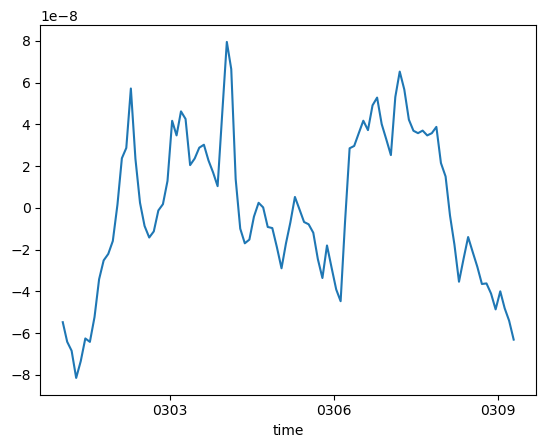

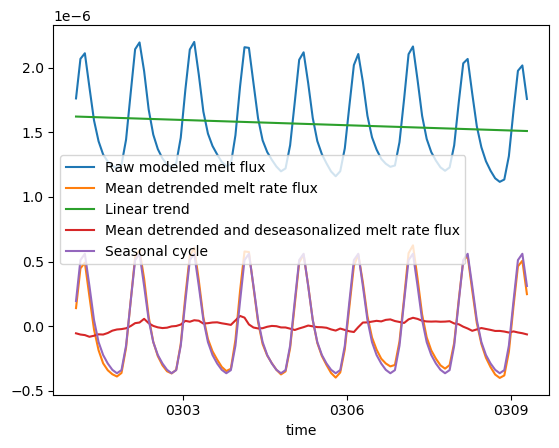

In [16]:
#plt.figure(figsize=(25,8))
SORRMv21_flux_ts[:100].plot(label='Raw modeled melt flux')
SORRMv21_flux_detrend_perpixel_ts.plot(label='Mean detrended melt rate flux')
(SORRMv21_flux_ts[:100]-SORRMv21_flux_detrend_perpixel_ts).plot(label='Linear trend')
SORRMv21_flux_detrend_perpixel_deseasonalize_ts.plot(label='Mean detrended and deseasonalized melt rate flux')
(SORRMv21_flux_detrend_perpixel_ts-SORRMv21_flux_detrend_perpixel_deseasonalize_ts).plot(label='Seasonal cycle')
plt.legend()

In [26]:
SORRMv21_seasonality = xr.open_dataset(main_dir / DIR_processed / 'sorrm/SORRMv21_seasonality.nc', chunks={"Time":36})
SORRMv21_variability = xr.open_dataset(main_dir / DIR_processed / 'sorrm/SORRMv21_variability.nc', chunks={"Time":36})

In [30]:
SORRMv21_seasonality

<xarray.Dataset>
Dimensions:                        (Time: 7200, x: 601, y: 601)
Coordinates:
  * Time                           (Time) object 0301-01-16 12:00:00.000001 ....
  * x                              (x) float64 -3e+06 -2.99e+06 ... 3e+06
  * y                              (y) float64 -3e+06 -2.99e+06 ... 3e+06
    lat                            (y, x) float64 dask.array<chunksize=(601, 601), meta=np.ndarray>
    lon                            (y, x) float64 dask.array<chunksize=(601, 601), meta=np.ndarray>
    month                          (Time) int64 dask.array<chunksize=(36,), meta=np.ndarray>
Data variables:
    __xarray_dataarray_variable__  (Time, y, x) float64 dask.array<chunksize=(36, 601, 601), meta=np.ndarray>

In [20]:
SORRMv21_seasonality_ts = SORRMv21_seasonality.mean(dim=['x','y']).compute()

In [27]:
SORRMv21_variability_ts = SORRMv21_variability.mean(dim=['x','y']).compute()

In [39]:
SORRMv21_variability = SORRMv21_variability.__xarray_dataarray_variable__

In [41]:
SORRMv21_variability

<xarray.DataArray '__xarray_dataarray_variable__' (Time: 7200, y: 457, x: 552)>
dask.array<open_dataset-280c79496b12bb2c403686af9d2dbf2a__xarray_dataarray_variable__, shape=(7200, 457, 552), dtype=float64, chunksize=(36, 457, 552), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 -2.32e+06 -2.31e+06 -2.3e+06 ... 2.23e+06 2.24e+06
  * x            (x) float64 -2.69e+06 -2.68e+06 -2.67e+06 ... 2.81e+06 2.82e+06
  * Time         (Time) object 0301-01-16 12:00:00.000001 ... 0900-12-16 12:0...
    month        (Time) int64 dask.array<chunksize=(36,), meta=np.ndarray>
    spatial_ref  int64 ...

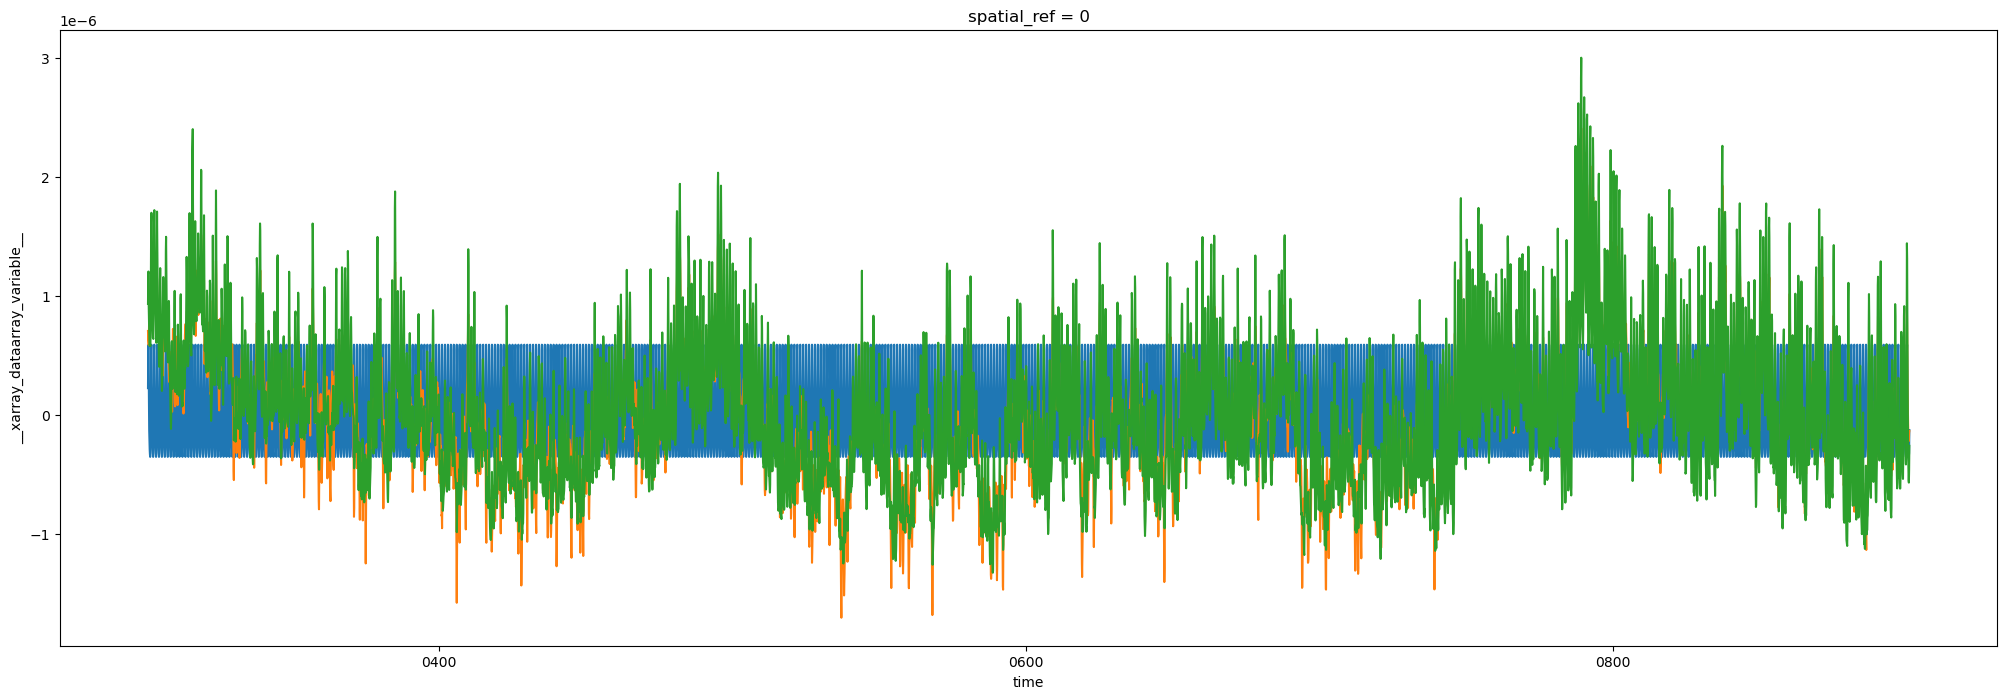

In [37]:
plt.figure(figsize=(25,8))
SORRMv21_seasonality_ts.__xarray_dataarray_variable__.plot()
SORRMv21_variability_ts.__xarray_dataarray_variable__.plot()
(SORRMv21_seasonality_ts+SORRMv21_variability_ts).__xarray_dataarray_variable__.plot()

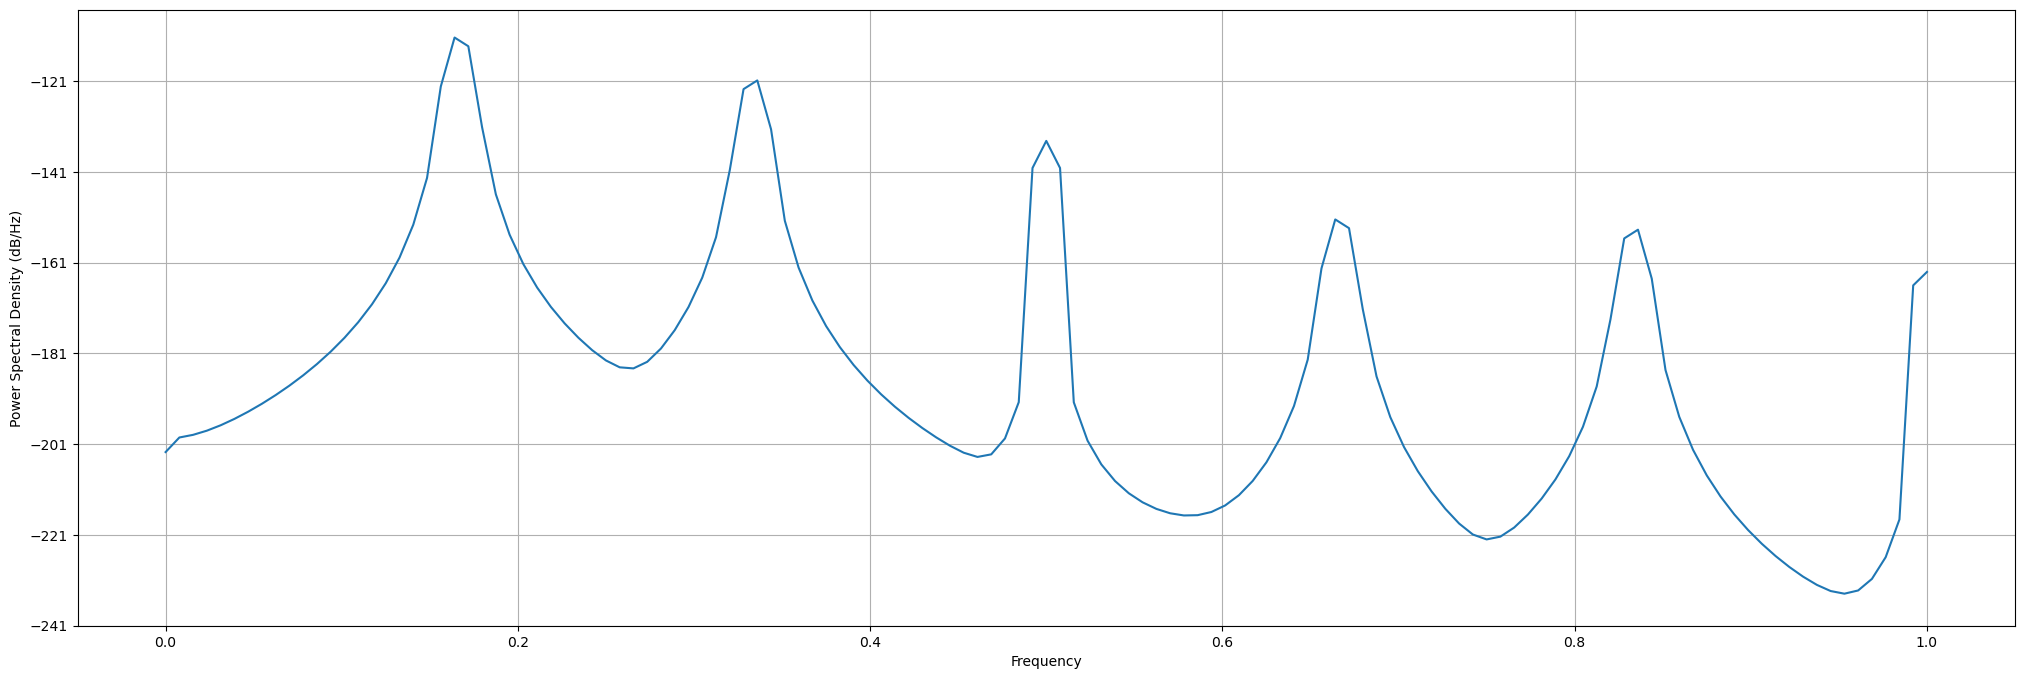

In [35]:
# Plot normalized power spectral densities for the melt rate time series

plt.figure(figsize=(25,8))
plt.psd(SORRMv21_seasonality_ts.__xarray_dataarray_variable__);
#plt.psd(SORRMv21_variability_ts.__xarray_dataarray_variable__);

# Draft dependence

In [189]:
iceShelfRegions = range(33,133)

def dedraft(data, draft):
    data_tm = data.mean(dim='Time')
    draft_tm = draft.mean(dim='Time')
    data_stack = data_tm.stack(z=('x', 'y'))
    draft_stack = draft_tm.stack(z=('x', 'y'))
    data_stack_noNaN = data_stack.fillna(0)
    draft_stack_noNaN = draft_stack.fillna(0)
    data_stack_noNaN_vals = data_stack_noNaN.values.reshape(-1,1)
    draft_stack_noNaN_vals = draft_stack_noNaN.values.reshape(-1,1)
    reg = LinearRegression().fit(draft_stack_noNaN_vals, data_stack_noNaN_vals)
    data_pred_stack_noNaN_vals = reg.predict(draft_stack_noNaN_vals).reshape(-1)
    data_pred_stack_noNaN = data_stack_noNaN.copy(data=data_pred_stack_noNaN_vals)
    data_pred_stack = data_pred_stack_noNaN.where(~data_stack.isnull(), np.nan)
    data_pred = data_pred_stack.unstack('z').transpose()
    #data_dedraft = data - data_pred
    return data_pred #reg.coef_, reg.intercept_, data_pred, data_dedraft


for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = clip_data(SORRMv21_flux_detrend_perpixel_deseasonalize, i)
    h = clip_data(SORRMv21_draft, i)
    mlt_tm = mlt.mean(dim='Time')
    h_tm = h.mean(dim='Time')
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_pred = dedraft(mlt, h)

    mlt_pred.name = 'draftDepenBasalMeltPred'
    mlt_pred.attrs['long_name'] = 'Predicted flux of mass through the ocean surface based on draft dependence coefficients. Positive into ocean.'
    mlt_pred.attrs['units'] = 'kg m^-2 s^-1'

    mlt_pred.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params_241014/sorrm/{}_draftPred.nc'.format(icems.name.values[i]))
    print('{} file saved'.format(icems.name.values[i]))

    del mlt, h, mlt_tm, h_tm, mlt_pred
    print('deleted interim variables')
    gc.collect()

extracting data for catchment Abbot
calculating linear regression for catchment Abbot
Abbot file saved
deleted interim variables
extracting data for catchment Amery
calculating linear regression for catchment Amery
Amery file saved
deleted interim variables
extracting data for catchment Atka
calculating linear regression for catchment Atka
Atka file saved
deleted interim variables
extracting data for catchment Aviator
calculating linear regression for catchment Aviator
Aviator file saved
deleted interim variables
extracting data for catchment Bach
calculating linear regression for catchment Bach
Bach file saved
deleted interim variables
extracting data for catchment Baudouin
calculating linear regression for catchment Baudouin
Baudouin file saved
deleted interim variables
extracting data for catchment Borchgrevink
calculating linear regression for catchment Borchgrevink
Borchgrevink file saved
deleted interim variables
extracting data for catchment Brahms
calculating linear regression 

2024-10-15 16:39:42,031 - distributed.worker - ERROR - Exception during execution of task ('getitem-where-mean_chunk-e19a97164f41e98e02d1677f61db0bf4', 82, 0, 0).
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/worker.py", line 2364, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/spill.py", line 257, in __getitem__
    return super().__getitem__(key)
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'original-open_dataset-ebcf316a66f8721c4ab652c43311056atimeMonthly_avg_ssh-c85607cd3d7b8e0e8e993027a308b3d5'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed

KeyboardInterrupt: 

# Plot data time series for randomly selected pixel locations

In [ ]:
climfit = (SORRMv21_flux_detrend_perpixel - SORRMv21_flux_detrend_perpixel_deseasonalize).compute()
climfit_ts = climfit.mean(dim=['x', 'y']).compute()

In [109]:
# Select a few points to plot time series of

def select_few_points(data, num_points=5):
    x_coords = random.sample(range(data.sizes['x']), num_points)
    y_coords = random.sample(range(data.sizes['y']), num_points)
    selected_points = list(zip(x_coords, y_coords))
    return selected_points

# Check for non-zero values in the selected points
def filter_non_zero_points(data, points):
    non_zero_points = []
    for (x, y) in points:
        if np.any(data[:, x, y] != 0):
            non_zero_points.append((x, y))
    return non_zero_points

# Extract time series of the selected points
def extract_time_series(data, points):
    time_series = {}
    for (x, y) in points:
        time_series[(x, y)] = data[:, x, y]
    return time_series

# Plot the time series of the selected points
def plot_time_series(time_series):
    plt.figure(figsize=(12, 8))
    for (x, y), series in time_series.items():
        plt.plot(series.Time, series, label=f'Pixel ({x}, {y})')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Time Series of Selected Pixels')
    plt.legend()
    plt.show()

In [104]:
# Combine all above functions to plot time series of selected points
def main(data, num_points=5):
    selected_points = select_few_points(data, num_points)
    non_zero_points = filter_non_zero_points(data, selected_points)
    time_series = extract_time_series(data, non_zero_points)
    plot_time_series(time_series)

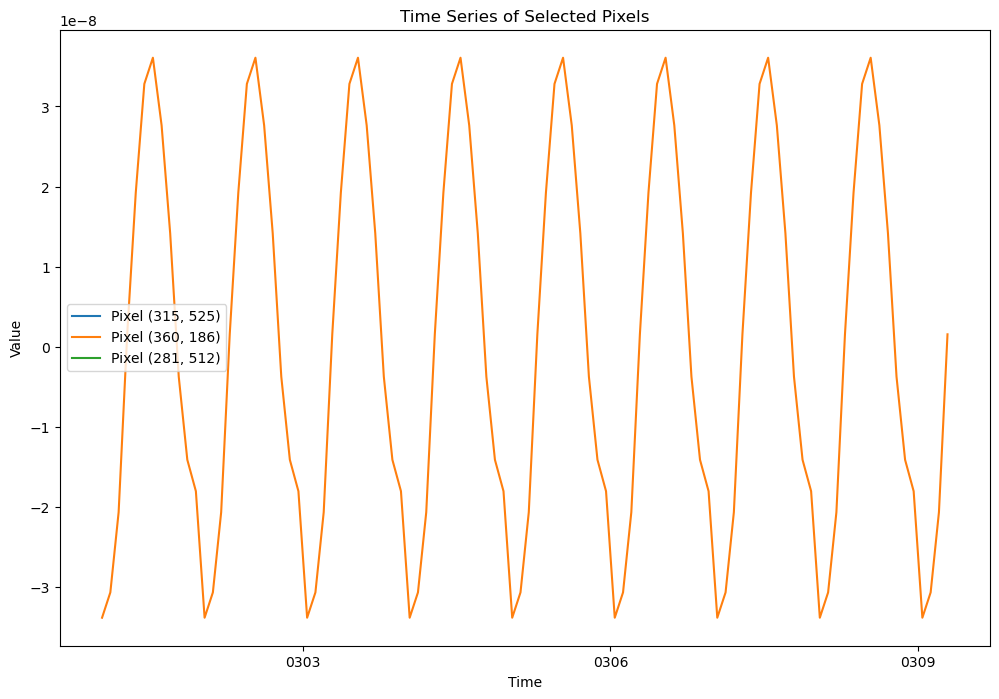

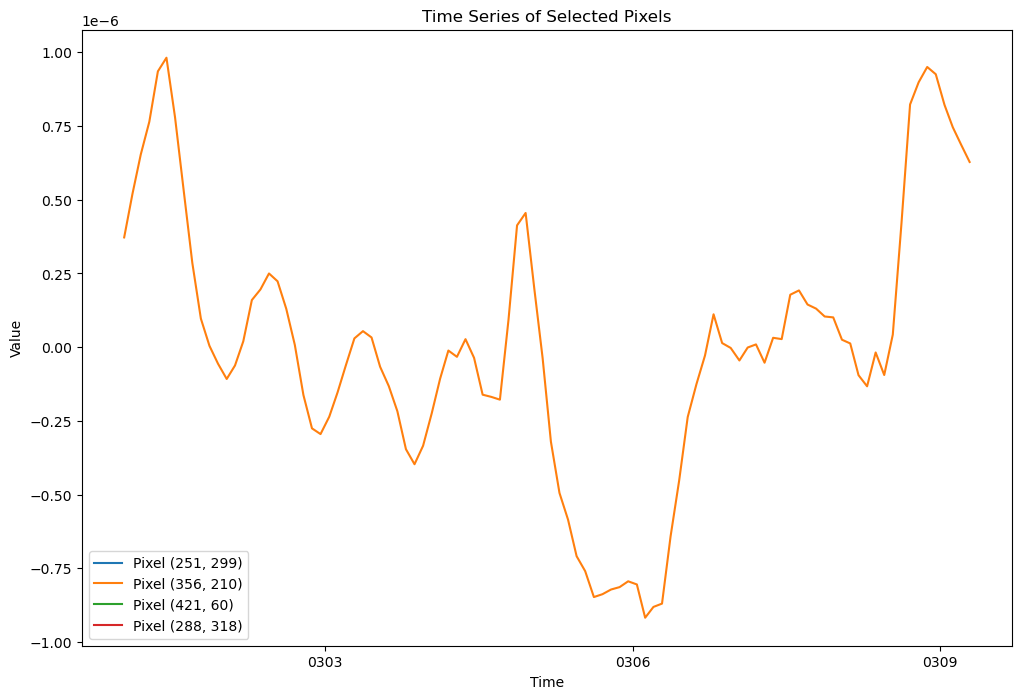

In [169]:
main(climfit, num_points=5)
main(SORRMv21_flux_detrend_perpixel_deseasonalize, num_points=5)